## 🧱 Imports and Environment Setup
This cell sets up the environment by importing necessary libraries such as PyTorch, torchvision, matplotlib, and other utility modules. It also detects whether to use GPU or CPU for model training.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 🗃️ Data Preparation with Progressive Resizing
In this section, we define two sets of data augmentations: one for low-resolution images (128×128) used in the warm-up phase, and another for high-resolution (224×224) used in fine-tuning. We also calculate class weights and use a `WeightedRandomSampler` to balance the classes during training.

In [2]:
data_dir = "knee"
class_names = sorted(os.listdir(os.path.join(data_dir, "train")))

# Initial low-resolution transforms for warm-up phase
train_transform_low = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

# High-resolution transforms for fine-tuning phase
train_transform_high = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform_low)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_transform)

class_counts = np.bincount([label for _, label in train_dataset])
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


## 🧠 Improved Model Architecture
This model uses ResNet-34 as a feature extractor and adds a deeper custom classifier head with dropout and batch normalization for better generalization.

In [3]:
class ImprovedKLClassifier(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.4):
        super(ImprovedKLClassifier, self).__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

model = ImprovedKLClassifier(num_classes=len(class_names)).to(device)


c:\uni\idp\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\uni\idp\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## ⚙️ Loss Function, Optimizer, and Scheduler
Here we define the training configuration using `CrossEntropyLoss` with class weights, `AdamW` optimizer for better weight decay handling, and a `ReduceLROnPlateau` scheduler that adjusts learning rate based on validation loss.

In [4]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6
)

from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()


c:\uni\idp\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\surya\AppData\Local\Temp\ipykernel_41496\436038492.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## 🔁 Training Loop with Mixed Precision and Progressive Resizing
This function handles model training using AMP (Automatic Mixed Precision) for faster training. We switch from low- to high-resolution images partway through training and use early stopping to prevent overfitting.

In [5]:
def train_model(model, train_loader, val_loader, epochs=25, warmup_epochs=8, patience=10):
    best_val_loss = float('inf')
    early_stopping_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Loss: {train_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model saved.")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("⛔ Early stopping triggered.")
                break

        # Switch to high-res transforms after warmup
        if epoch + 1 == warmup_epochs:
            train_loader.dataset.transform = train_transform_high

    return history

history = train_model(model, train_loader, val_loader)


C:\Users\surya\AppData\Local\Temp\ipykernel_41496\2678285691.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/25 → Train Acc: 0.4105, Val Acc: 0.0327, Loss: 0.7979
✅ Model saved.
Epoch 2/25 → Train Acc: 0.5372, Val Acc: 0.0400, Loss: 0.4922
✅ Model saved.
Epoch 3/25 → Train Acc: 0.5945, Val Acc: 0.0617, Loss: 0.4246
Epoch 4/25 → Train Acc: 0.6101, Val Acc: 0.0387, Loss: 0.3773
Epoch 5/25 → Train Acc: 0.6322, Val Acc: 0.0363, Loss: 0.3479
Epoch 6/25 → Train Acc: 0.6329, Val Acc: 0.0823, Loss: 0.3727
Epoch 7/25 → Train Acc: 0.6663, Val Acc: 0.1041, Loss: 0.3032
Epoch 8/25 → Train Acc: 0.6710, Val Acc: 0.1235, Loss: 0.3169
✅ Model saved.
Epoch 9/25 → Train Acc: 0.5877, Val Acc: 0.4274, Loss: 0.4421
✅ Model saved.
Epoch 10/25 → Train Acc: 0.6651, Val Acc: 0.4504, Loss: 0.3196
✅ Model saved.
Epoch 11/25 → Train Acc: 0.6938, Val Acc: 0.5278, Loss: 0.2867
✅ Model saved.
Epoch 12/25 → Train Acc: 0.7169, Val Acc: 0.5496, Loss: 0.2859
✅ Model saved.
Epoch 13/25 → Train Acc: 0.7271, Val Acc: 0.5278, Loss: 0.2582
✅ Model saved.
Epoch 14/25 → Train Acc: 0.7615, Val Acc: 0.6186, Loss: 0.2240
✅ Model

## 📊 Training Curves
This section plots training and validation accuracy and loss over epochs to visually inspect how the model is learning.

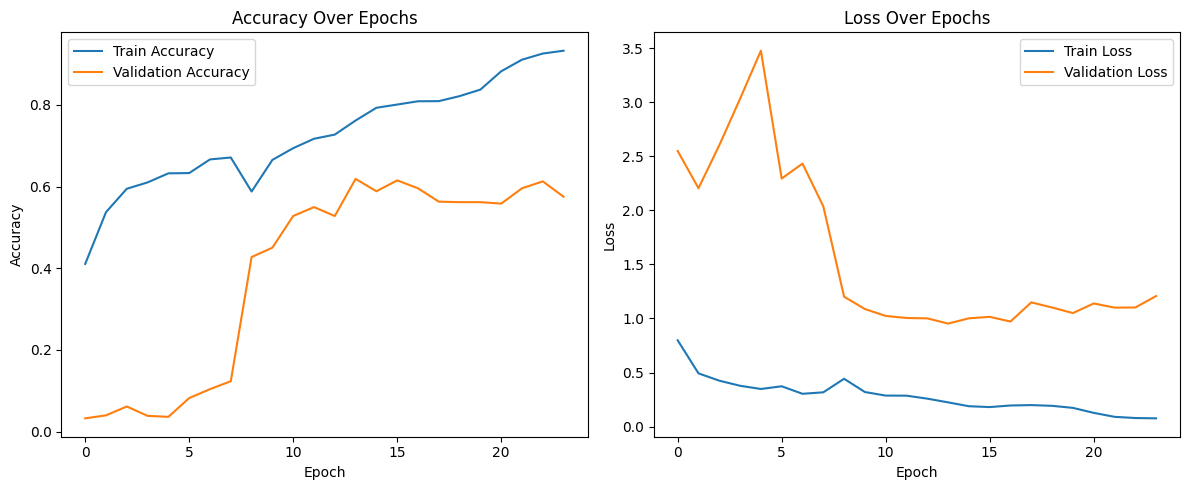

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


## 🧪 Evaluation on Test Set
We load the best model and evaluate it on the test set. The classification report shows precision, recall, and F1-score for each class.

In [7]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


C:\Users\surya\AppData\Local\Temp\ipykernel_41496\4104377613.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       639
           1       0.26      0.23      0.24       296
           2       0.71      0.40      0.51       447
           3       0.80      0.78      0.79       223
           4       0.84      0.92      0.88        51

    accuracy                           0.62      1656
   macro avg       0.65      0.64      0.63      1656
weighted avg       0.62      0.62      0.60      1656



## Confusion Matrix

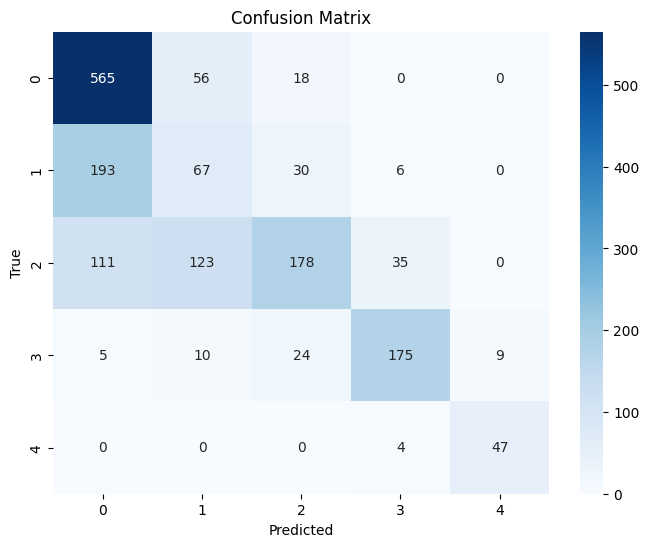

In [8]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 🔁 Test-Time Augmentation Function

This cell defines a helper function to perform **Test-Time Augmentation (TTA)**.

Instead of making a prediction on just one transformed image, TTA applies multiple random augmentations to the same image and averages the softmax probabilities from all predictions. This often improves classification robustness and confidence, especially on noisy or borderline cases.

- `model`: Trained CNN model.
- `image`: PIL image to classify.
- `transform`: Same as used for validation/test (e.g., center crop, resize, etc.).
- `num_augmentations`: Number of augmentations to apply (default = 10).
- Returns: Predicted class index and the averaged confidence score.


In [1]:

def test_time_augmentation(model, image, transform, num_augmentations=10):
    model.eval()
    image_tensor = transform(image).unsqueeze(0).to(device)
    preds = []

    with torch.no_grad():
        for _ in range(num_augmentations):
            aug_image = transform(image).unsqueeze(0).to(device)
            output = model(aug_image)
            probs = F.softmax(output, dim=1)
            preds.append(probs)

    avg_probs = torch.stack(preds).mean(dim=0)
    confidence, predicted_class = torch.max(avg_probs, 1)
    return predicted_class.item(), confidence.item()


## 🖼️ Single Image Prediction with Visualization

This function wraps the TTA-based prediction for a **single image**, displaying the image and predicted KL grade along with the model's confidence.

Steps:
1. Loads and preprocesses a single image.
2. Performs TTA-based inference.
3. Prints predicted class and confidence.
4. Displays the image with the predicted label as the title.

This is useful for quick visual verification of the model's performance on individual samples.


In [2]:
# Cell 12: Single Image Prediction Example
def predict_knee_grade(model, image_path, class_names, transform):
    image = Image.open(image_path).convert("RGB")
    predicted_class, confidence = test_time_augmentation(model, image, transform, num_augmentations=10)
    print(f"🔍 Predicted KL Grade: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2%})")
    plt.axis('off')
    plt.show()
    return predicted_class, confidence

# Example usage (uncomment and set your image path):
predict_knee_grade(model, "knee/val/2/9015402R.png", class_names, val_transform)


NameError: name 'model' is not defined

## 📂 Batch Prediction on Directory

This function performs **batch prediction** over all `.png`, `.jpg`, or `.jpeg` images in a specified directory using **Test-Time Augmentation**.

It prints predictions for each image and aggregates results in a pandas DataFrame containing:
- `filename`
- `predicted_class` (as numeric label)
- `predicted_label` (KL-0 to KL-4)
- `confidence`

Ideal for running inference on a large set of test images and saving the results as a CSV for later analysis or reporting.


In [ ]:
# Cell 13: 📁 Batch Prediction on Directory
def predict_directory(model, directory_path, class_names, transform):
    results = []
    for filename in os.listdir(directory_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(directory_path, filename)
            print(f"📸 Predicting {filename}...")
            image = Image.open(image_path).convert("RGB")
            predicted_class, confidence = test_time_augmentation(model, image, transform)
            print(f"🔍 Predicted KL Grade: {class_names[predicted_class]} (Confidence: {confidence:.2%})\n")
            results.append({
                "filename": filename,
                "predicted_class": predicted_class,
                "predicted_label": class_names[predicted_class],
                "confidence": confidence
            })

    results_df = pd.DataFrame(results)
    return results_df

# ✅ Example usage (uncomment to run):
results_df = predict_directory(model, "knee/val/4", class_names, val_transform)
# results_df.to_csv("prediction_results.csv", index=False)


📸 Predicting 9006140L.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 91.14%)

📸 Predicting 9006140R.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 91.82%)

📸 Predicting 9009067L.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 46.53%)

📸 Predicting 9009067R.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 72.91%)

📸 Predicting 9015402L.png...
🔍 Predicted KL Grade: KL-1 (Confidence: 42.90%)

📸 Predicting 9024900L.png...
🔍 Predicted KL Grade: KL-1 (Confidence: 57.70%)

📸 Predicting 9024900R.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 59.10%)

📸 Predicting 9026695R.png...
🔍 Predicted KL Grade: KL-1 (Confidence: 34.54%)

📸 Predicting 9030925L.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 95.60%)

📸 Predicting 9030925R.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 94.80%)

📸 Predicting 9031141L.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 29.70%)

📸 Predicting 9034812R.png...
🔍 Predicted KL Grade: KL-0 (Confidence: 80.03%)

📸 Predicting 9043446L.png...
🔍 Predicted KL Grade: KL-0 (Confide